# Setup and Imports



In [ ]:
# --- Core libraries ---
import pandas as pd
from pathlib import Path
import pm4py
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn import converter as bpmn_to_petri_converter



# --- Column aliases used throughout ---
CASE = "case:concept:name"
ACT  = "concept:name"
TS   = "time:timestamp"
LIFE = "lifecycle:transition"


# Eventlog loading and pre-processing

In [3]:
xes_path = Path("../data/raw/BPI_Challenge_2017.xes")

# EventLog loading
elog = pm4py.read_xes(str(xes_path))

# DataFrame 
df = pm4py.convert_to_dataframe(elog)
df[TS] = pd.to_datetime(df[TS], errors="coerce")
df = df.sort_values([CASE, TS]).reset_index(drop=True)


c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\pm4py\utils.py:991: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

# Inductive Miner Discovery

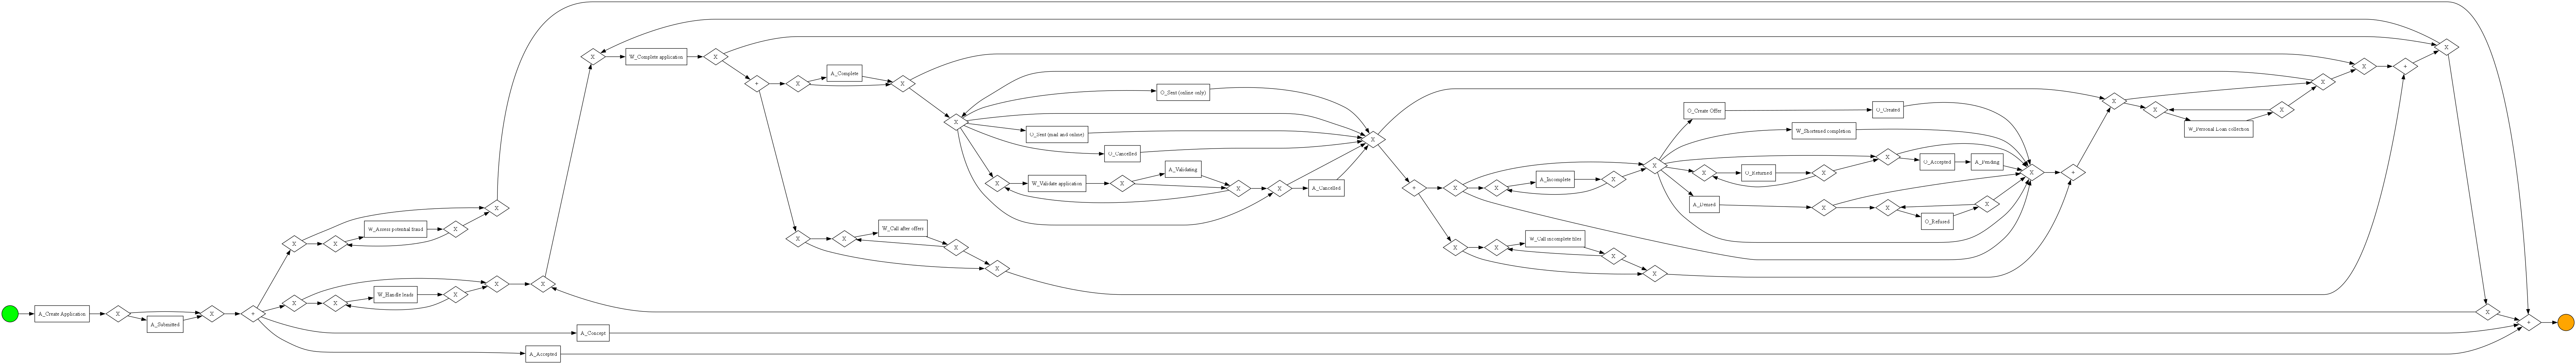

BPMN-Modell gespeichert unter: ..\models\inductive_model.bpmn


In [ ]:
# --- Process Discovery (Inductive Miner) ---
net_im, im_initial_marking, im_final_marking = pm4py.discover_petri_net_inductive(elog)

# --- Convert to BPMN ---
bpmn_im = pm4py.convert_to_bpmn(net_im, im_initial_marking, im_final_marking)

# --- Visualize BPMN ---
gviz_im = bpmn_visualizer.apply(bpmn_im)
bpmn_visualizer.view(gviz_im)

# --- Save BPMN to /models ---
output_path = Path("../models/inductive_model.bpmn")
output_path.parent.mkdir(parents=True, exist_ok=True)

pm4py.write_bpmn(bpmn_im, str(output_path))

# Heuristics Miner Discovery

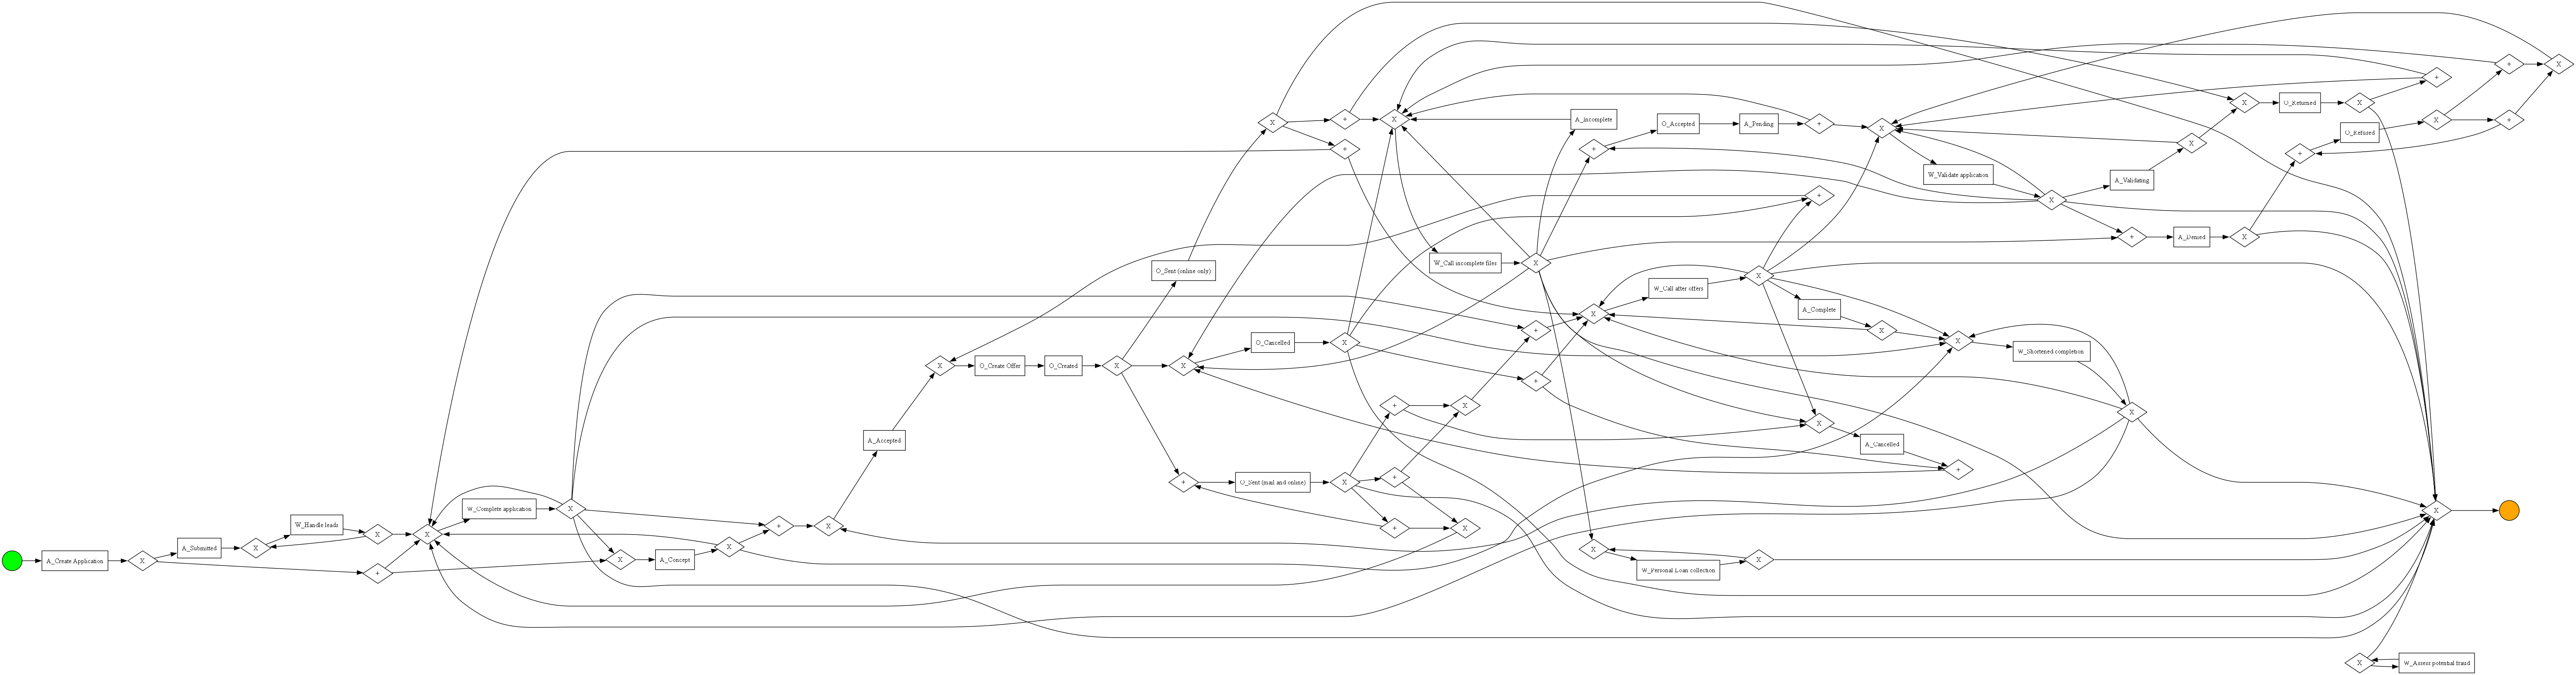

In [ ]:
# --- Process Discovery (Heuristics Miner) ---
net_hm, hm_initial_marking, hm_final_marking = pm4py.discover_petri_net_heuristics(elog)

# --- Convert to BPMN ---
bpmn_hm = pm4py.convert_to_bpmn(net_hm, hm_initial_marking, hm_final_marking)

# --- Visualize ---
gviz_hm = bpmn_visualizer.apply(bpmn_hm)
bpmn_visualizer.view(gviz_hm)

# --- Save BPMN to /models ---
output_path_hm = Path("../models/heuristics_model.bpmn")
output_path_hm.parent.mkdir(parents=True, exist_ok=True)

pm4py.write_bpmn(bpmn_hm, str(output_path_hm))


# Alpha Miner Disovery

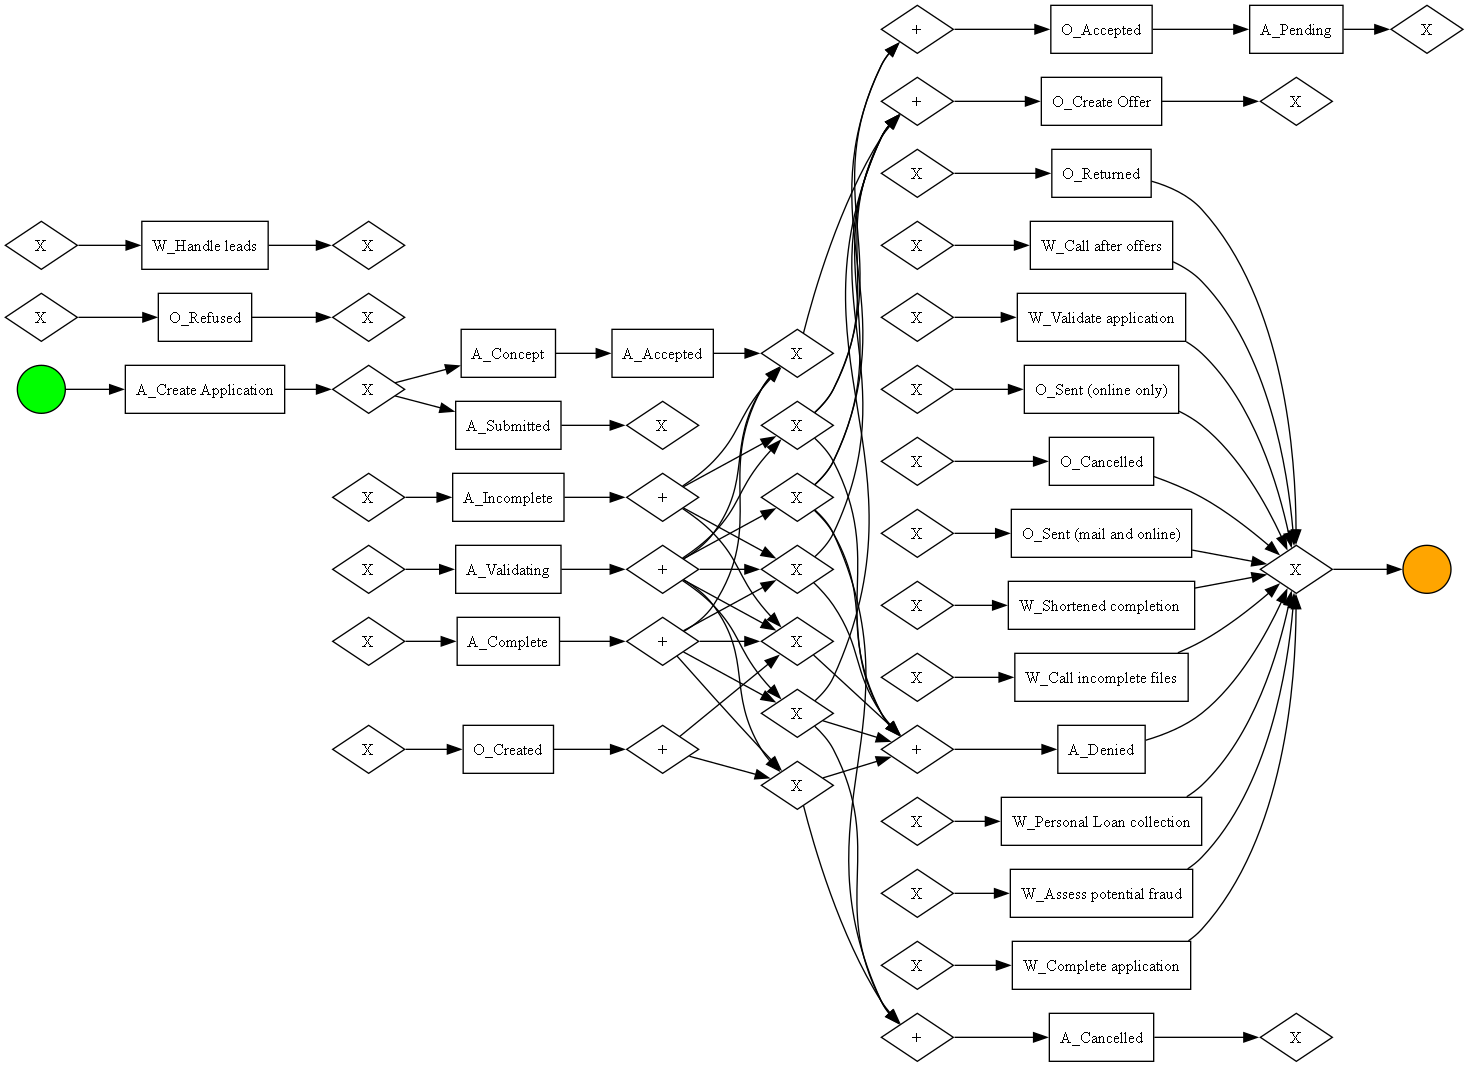

In [4]:
# --- Process Discovery (Alpha Miner) ---
net_alpha, alpha_initial_marking, alpha_final_marking = pm4py.discover_petri_net_alpha(elog)

# --- Convert to BPMN ---
bpmn_alpha = pm4py.convert_to_bpmn(net_alpha, alpha_initial_marking, alpha_final_marking)

# --- Visualize ---
gviz_alpha = bpmn_visualizer.apply(bpmn_alpha)
bpmn_visualizer.view(gviz_alpha)

# --- Save BPMN to /models ---
output_path_alpha = Path("../models/alpha_model.bpmn")
output_path_alpha.parent.mkdir(parents=True, exist_ok=True)

pm4py.write_bpmn(bpmn_alpha, str(output_path_alpha))


## Quality Criteria Overview (Fitness, Precision, Generalization, Simplicity)
We assess discovered models along four dimensions:
- **Fitness**: How well the model can replay the observed log traces (token-based replay for speed).
- **Precision**: How much extraneous behavior the model allows beyond the log (lower allowance = higher precision).
- **Generalization**: Ability to cover unseen but similar behavior (avoid overfitting to variants).
- **Simplicity**: Structural parsimony. We implement custom metrics (size, density, silent transition ratio, avg branching) to compare structural complexity.

# Evaluation (Replay Fitness)

In [29]:
fitness_im = pm4py.fitness_token_based_replay(
    elog,
    net_im,
    im_initial_marking,
    im_final_marking,
)

fitness_hm = pm4py.fitness_token_based_replay(
    elog,
    net_hm,
    hm_initial_marking,
    hm_final_marking,
)

fitness_summary = pd.DataFrame(
    [
        {
            "model": "inductive",
            "fitness_log (%)": round(fitness_im["log_fitness"] * 100, 2),
        },
        {
            "model": "heuristics",
            "fitness_log (%)": round(fitness_hm["log_fitness"] * 100, 2),
        },
    ]
)

display(fitness_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,fitness_log (%)
0,inductive,100.00
1,heuristics,95.46


Fitness Alpha Miner:

In [39]:
fitness_alpha = pm4py.fitness_token_based_replay(
    elog,
    net_alpha,
    alpha_initial_marking,
    alpha_final_marking,
)

fitness_alpha_summary = pd.DataFrame(
    [
        {
            "model": "alpha",
            "fitness_log (%)": round(fitness_alpha["log_fitness"] * 100, 2),
        }
    ]
)

display(fitness_alpha_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,fitness_log (%)
0,alpha,38.26


# Evaluation (Precision)

In [31]:
precision_im = pm4py.precision_token_based_replay(
    elog,
    net_im,
    im_initial_marking,
    im_final_marking,
)

precision_hm = pm4py.precision_token_based_replay(
    elog,
    net_hm,
    hm_initial_marking,
    hm_final_marking,
)

precision_summary = pd.DataFrame(
    [
        {
            "model": "inductive",
            "precision (%)": round(precision_im * 100, 2),
        },
        {
            "model": "heuristics",
            "precision (%)": round(precision_hm * 100, 2),
        },
    ]
)

display(precision_summary)


Exception in thread Thread-3:
Traceback (most recent call last):
  File "C:\Users\mertb\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\tqdm\_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\tqdm\std.py", line 1347, in refresh
    self.display()
  File "c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\tqdm\notebook.py", line 157, in display
    pbar.value = self.n
  File "c:\TUM Master\Business Process Prediction, Simulation and Optimization\Assignment 1\.venv\lib\site-packages\traitlets\traitlets.py", line 716, in __set__
    instance.refresh(nolock=True)
  File "c:\TUM Master\Business Process Prediction, Simulation and Optimizat

replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

,model,precision (%)
0,inductive,14.07
1,heuristics,67.11


Precision Alpha Miner:

In [40]:
precision_alpha = pm4py.precision_token_based_replay(
    elog,
    net_alpha,
    alpha_initial_marking,
    alpha_final_marking,
)

precision_alpha_summary = pd.DataFrame(
    [
        {
            "model": "alpha",
            "precision (%)": round(precision_alpha * 100, 2),
        }
    ]
)

display(precision_alpha_summary)


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

,model,precision (%)
0,alpha,9.04


# Evaluation (Generalization)

In [33]:
generalization_im = generalization_evaluator.apply(
    elog,
    net_im,
    im_initial_marking,
    im_final_marking
)

generalization_hm = generalization_evaluator.apply(
    elog,
    net_hm,
    hm_initial_marking,
    hm_final_marking
)

generalization_summary = pd.DataFrame(
    [
        {
            "model": "inductive",
            "generalization (%)": round(generalization_im * 100, 2),
        },
        {
            "model": "heuristics",
            "generalization (%)": round(generalization_hm * 100, 2),
        },
    ]
)

display(generalization_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,generalization (%)
0,inductive,94.85
1,heuristics,92.89


Generalization Alpha Miner:

In [45]:
generalization_alpha = generalization_evaluator.apply(
    elog,
    net_alpha,
    alpha_initial_marking,
    alpha_final_marking
)

generalization_alpha_summary = pd.DataFrame(
    [
        {
            "model": "alpha",
            "generalization (%)": round(generalization_alpha * 100, 2),
        }
    ]
)

display(generalization_alpha_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,generalization (%)
0,alpha,98.24


# Simplicity-Metrics

In [13]:
def compute_simplicity_metrics(net):
    # basic structural counts
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)

    node_count = num_places + num_transitions

    # metric 1: Node Count Simplicity (fewer nodes → simpler model)
    simplicity_node_count = 1 / (1 + node_count)

    # metric 2: Arc Density Simplicity (fewer arcs per node → simpler model)
    arc_node_ratio = num_arcs / node_count if node_count > 0 else float("nan")
    simplicity_arc_density = 1 / (1 + arc_node_ratio) if arc_node_ratio > 0 else float("nan")

    return {
        "num_places": num_places,
        "num_transitions": num_transitions,
        "num_arcs": num_arcs,
        "node_count": node_count,
        "arc_node_ratio": arc_node_ratio,
        "simplicity_node_count": simplicity_node_count,
        "simplicity_arc_density": simplicity_arc_density,
    }


# Compute simplicity for all three models
simplicity_im = compute_simplicity_metrics(net_im)
simplicity_hm = compute_simplicity_metrics(net_hm)
simplicity_alpha = compute_simplicity_metrics(net_alpha)

# Summary table
simplicity_summary = pd.DataFrame(
    [
        {"model": "inductive", **simplicity_im},
        {"model": "heuristics", **simplicity_hm},
        {"model": "alpha", **simplicity_alpha},
    ]
)

display(simplicity_summary)


NameError: name 'net_im' is not defined

# Comparison Table

In [ ]:
summary = pd.DataFrame(
    [
        {
            "model": "inductive",
            "fitness (%)": round(fitness_im["log_fitness"] * 100, 2),
            "precision (%)": round(precision_im * 100, 2),
            "generalization (%)": round(generalization_im * 100, 2),

            "Node Count Simplicity": round(simplicity_im["simplicity_node_count"], 6),
            "Arc Density Simplicity": round(simplicity_im["simplicity_arc_density"], 6),
        },
        {
            "model": "heuristics",
            "fitness (%)": round(fitness_hm["log_fitness"] * 100, 2),
            "precision (%)": round(precision_hm * 100, 2),
            "generalization (%)": round(generalization_hm * 100, 2),

            "Node Count Simplicity": round(simplicity_hm["simplicity_node_count"], 6),
            "Arc Density Simplicity": round(simplicity_hm["simplicity_arc_density"], 6),
        },
        {
            "model": "alpha",
            "fitness (%)": round(fitness_alpha["log_fitness"] * 100, 2),
            "precision (%)": round(precision_alpha * 100, 2),
            "generalization (%)": round(generalization_alpha * 100, 2),

            "Node Count Simplicity": round(simplicity_alpha["simplicity_node_count"], 6),
            "Arc Density Simplicity": round(simplicity_alpha["simplicity_arc_density"], 6),
        },
    ]
)

display(summary)


,model,fitness (%),precision (%),generalization (%),Node Count Simplicity,Arc Density Simplicity
0,inductive,100.00,14.07,94.85,0.006993,0.435583
1,heuristics,95.46,67.11,92.89,0.007937,0.405844
2,alpha,38.26,9.04,98.24,0.025641,0.408602


: 

# Own Process Model Analysis


In [6]:
# Loading own process model
manual_bpmn_path = Path("../models/BPIC17_Own Process Model.bpmn")
bpmn_manual = bpmn_importer.apply(str(manual_bpmn_path))

# --- Convert BPMN → Petri Net (for replay & metrics) ---
net_manual, im_manual, fm_manual = bpmn_to_petri_converter.apply(bpmn_manual)
print("Manual BPMN successfully loaded and converted to Petri net.")

Manual BPMN successfully loaded and converted to Petri net.


Replay Fitness

In [9]:
fitness_manual = pm4py.fitness_token_based_replay(
    elog,
    net_manual,
    im_manual,
    fm_manual,
)

fitness_manual_summary = pd.DataFrame(
    [
        {
            "model": "manual",
            "fitness_log (%)": round(fitness_manual["log_fitness"] * 100, 2),
        }
    ]
)

display(fitness_manual_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,fitness_log (%)
0,manual,94.06


Precision 

In [10]:
precision_manual = pm4py.precision_token_based_replay(
    elog,
    net_manual,
    im_manual,
    fm_manual,
)

precision_manual_summary = pd.DataFrame(
    [
        {
            "model": "manual",
            "precision (%)": round(precision_manual * 100, 2),
        }
    ]
)

display(precision_manual_summary)


replaying log with TBR, completed traces ::   0%|          | 0/263907 [00:00<?, ?it/s]

,model,precision (%)
0,manual,48.18


Generalization

In [12]:
generalization_manual = generalization_evaluator.apply(
    elog,
    net_manual,
    im_manual,
    fm_manual
)

generalization_manual_summary = pd.DataFrame(
    [
        {
            "model": "manual",
            "generalization (%)": round(generalization_manual * 100, 2),
        }
    ]
)

display(generalization_manual_summary)


replaying log with TBR, completed traces ::   0%|          | 0/15930 [00:00<?, ?it/s]

,model,generalization (%)
0,manual,97.51


Simplicity

In [14]:
simplicity_manual = compute_simplicity_metrics(net_manual)

simplicity_manual_summary = pd.DataFrame(
    [{
        "model": "manual",
        "Node Count Simplicity": round(simplicity_manual["simplicity_node_count"], 6),
        "Arc Density Simplicity": round(simplicity_manual["simplicity_arc_density"], 6)
    }]
)

display(simplicity_manual_summary)


,model,Node Count Simplicity,Arc Density Simplicity
0,manual,0.011111,0.465969


General Table


In [15]:
manual_complete = pd.DataFrame([
    {
        "model": "manual",
        "fitness (%)": round(fitness_manual["log_fitness"] * 100, 2),
        "precision (%)": round(precision_manual * 100, 2),
        "generalization (%)": round(generalization_manual * 100, 2),
        "Node Count Simplicity": round(simplicity_manual["simplicity_node_count"], 6),
        "Arc Density Simplicity": round(simplicity_manual["simplicity_arc_density"], 6)
    }
])

display(manual_complete)


,model,fitness (%),precision (%),generalization (%),Node Count Simplicity,Arc Density Simplicity
0,manual,94.06,48.18,97.51,0.011111,0.465969
